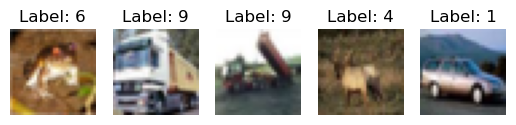

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# CIFAR-10 数据加载函数
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')  # 用 bytes 读取
        images = data_dict[b'data']                  # 图像数据，形状为 (10000, 3072)
        labels = data_dict[b'labels']                # 标签
        images = images.reshape((10000, 3, 32, 32))  # 转换为 (N, C, H, W)
        images = images.transpose(0, 2, 3, 1)        # 转换为 (N, H, W, C)
        return images, labels

# 指定路径
data_path = '../cifar10/cifar-10-batches-py'
batch_file = os.path.join(data_path, 'data_batch_1')

# 加载第一个 batch
images, labels = load_cifar10_batch(batch_file)

# 显示前5张图片
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.show()


In [2]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        labels_onehot = np.zeros((len(labels), 10))
        for n,label in enumerate(labels):
            labels_onehot[n][label] = 1
        
        return images, labels_onehot

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)


train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


In [3]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000, 10)


In [4]:
# 划分 train/dev/test
train_set = (train_images[:45000], train_labels[:45000])
dev_set   = (train_images[45000:], train_labels[45000:])
test_set  = (test_images, test_labels)


In [5]:
import numpy as np

print("Min pixel value:", np.min(test_images))
print("Max pixel value:", np.max(test_images))


Min pixel value: 0.0
Max pixel value: 1.0


In [6]:
print(test_set[0].shape,test_set[1].shape)

(10000, 3, 32, 32) (10000, 10)


Displaying first 5 images from test set...


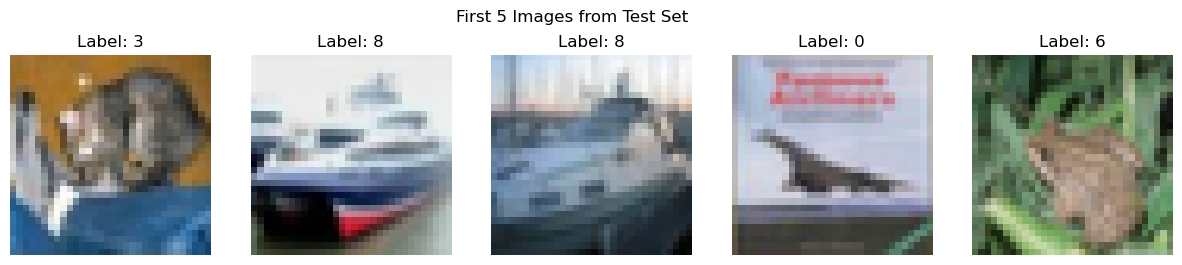

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, title=""):
    """
    绘制并显示图片（前五张）
    - images: 形状 (N, C, H, W)
    - labels: 形状 (N,) 或 (N, C)（one-hot 或 标签索引格式）
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 显示 5 张图片
    for i in range(5):
        ax = axes[i]
        img = images[i].transpose(1, 2, 0)  # 转换为 (H, W, C) 形状
        ax.imshow(img)
        ax.set_title(f"Label: {np.argmax(labels[i])}")  # 显示标签
        ax.axis('off')
    plt.suptitle(title)
    plt.show()


# 打印训练集样本的前五张图片
print("Displaying first 5 images from test set...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")


In [8]:
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
from mynn.attack import fgsm_attack

In [9]:
layers = [
    Conv(in_channel=3, out_channel=32, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3)),
    ReLU(),
    Pooling(kernel=2),  # 输出: (N, 32, 16, 16)

    Conv(in_channel=32, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3)),
    ReLU(),
    Pooling(kernel=2),  # 输出: (N, 64, 8, 8)

    Flatten(),          # 输出: (N, 4096)
    Dropout(rate=0.5),

    Linear(in_channel=4096, out_channel=512, weight_decay=0.001),  # 分类 10 类
    Linear(in_channel=512, out_channel=10, weight_decay=0.001)
]


In [10]:
model = Model(layers)
optimizer = Adam(model=model, lr=0.001)
loss_fn  = CrossEntropy(model=model)
runner  = RunnerM(model=model, loss=loss_fn, optimizer=optimizer)

Epoch 1/5: 100%|██████████| 704/704 [01:03<00:00, 11.09batch/s, accuracy=0.75, loss=1]    
train_loss: 1.31639, train_acc: 0.51275
dev_loss  : 1.33869, dev_acc  : 0.50664
### Best model saved to: best_models\2025-05-13_14-47-22\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.50664
Patience Counter Reset to 0

Epoch 2/5: 100%|██████████| 704/704 [01:04<00:00, 11.00batch/s, accuracy=0.5, loss=1.49]   
train_loss: 1.17548, train_acc: 0.59046
dev_loss  : 1.21735, dev_acc  : 0.57015
### Best model saved to: best_models\2025-05-13_14-47-22\best_model.pickle
### Best validation accuracy updated: 0.50664 -> 0.57015
Patience Counter Reset to 0

Epoch 3/5: 100%|██████████| 704/704 [01:04<00:00, 11.00batch/s, accuracy=0.75, loss=0.963] 
train_loss: 1.08103, train_acc: 0.62033
dev_loss  : 1.11752, dev_acc  : 0.60534
### Best model saved to: best_models\2025-05-13_14-47-22\best_model.pickle
### Best validation accuracy updated: 0.57015 -> 0.60534
Patience Counter Reset to 0

Ep

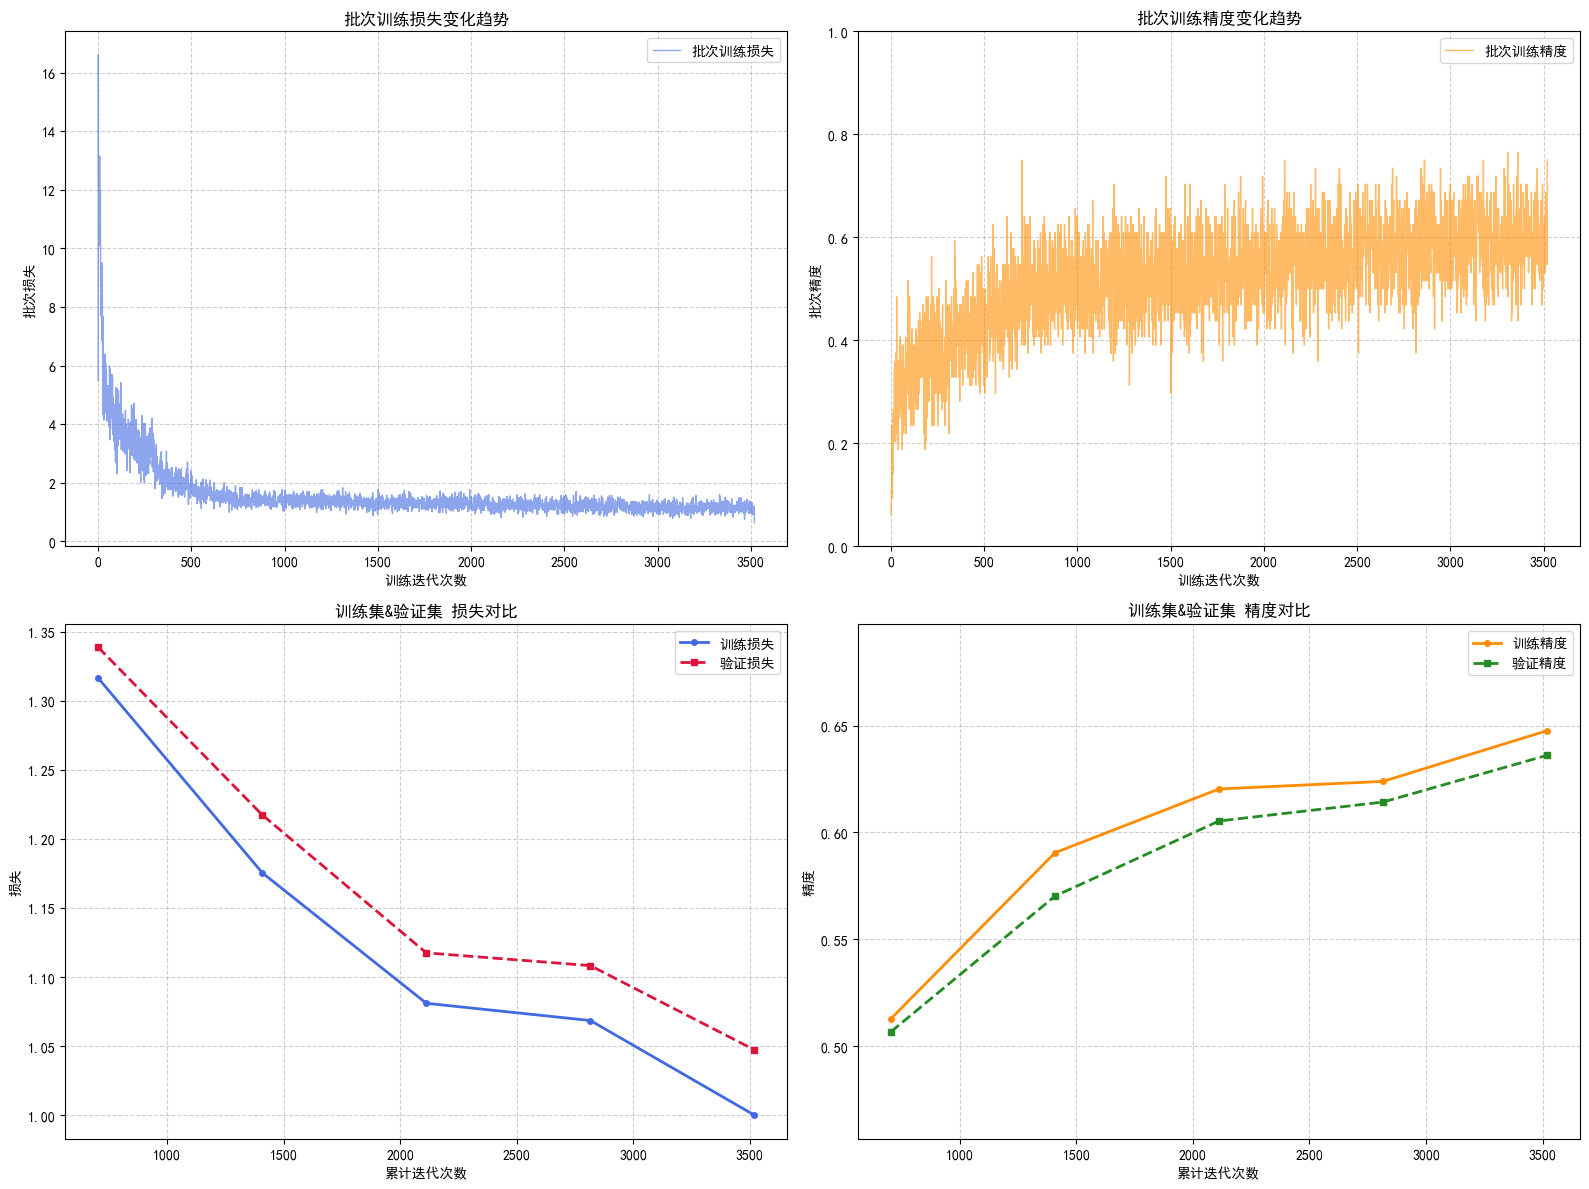

In [11]:
runner.train(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=64,
        num_epochs=5,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        shuffle=True,
        save_dir='best_models'
    )


In [12]:
test_loss, test_acc = runner.evaluate(test_set, batch_size=64)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 1.06384, Test accuracy: 0.62321


In [15]:

adv_test_images = fgsm_attack(
    model=model, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=1/255.0  
)

test_set_adv = (adv_test_images, test_labels)



In [12]:
print("Min pixel value:", np.min(adv_test_images))
print("Max pixel value:", np.max(adv_test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [42]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")


Adversarial Test loss: 1.54530, Test accuracy: 0.43531


In [38]:
def plot_images(images, labels, title=""):
    """
    显示前五张图片，自动处理 Cupy/NumPy、范围归一化等
    - images: (N, C, H, W)，可为 Cupy 或 NumPy
    - labels: (N,) 或 (N, C)
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(5):
        ax = axes[i]

        # 取单张图片，并转 (H, W, C)
        img = images[i].transpose(1, 2, 0)

        # 如果是 cupy，则转为 numpy
        if hasattr(img, 'get'):
            img = img.get()

        # 如果像素最大值超过1，说明是 [0, 255]，就归一化
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)  # 保险剪裁，防止 overflow

        ax.imshow(img)
        # 标签显示
        label = labels[i]
        label_text = np.argmax(label) if len(label.shape) > 0 and label.shape[0] > 1 else label
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.show()


Displaying original images...


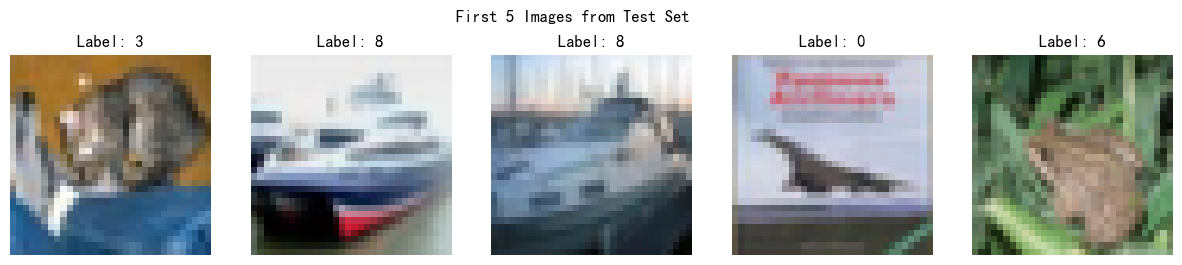

Displaying adversarial images...


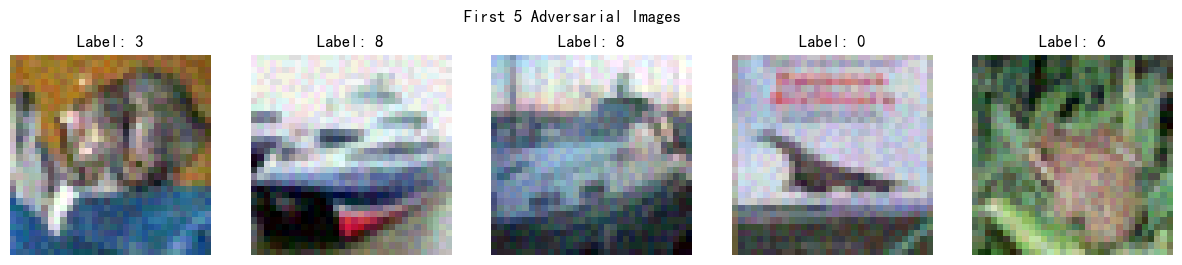

In [39]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")


对抗训练部分：

In [9]:
layers2 = [
    Conv(in_channel=3, out_channel=32, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3)),
    ReLU(),
    Pooling(kernel=2),  # 输出: (N, 32, 16, 16)

    Conv(in_channel=32, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3)),
    ReLU(),
    Pooling(kernel=2),  # 输出: (N, 64, 8, 8)

    Flatten(),          # 输出: (N, 4096)
    Dropout(rate=0.5),

    Linear(in_channel=4096, out_channel=512, weight_decay=0.001),  # 分类 10 类
    Linear(in_channel=512, out_channel=10, weight_decay=0.001)
]

In [10]:
model2 = Model(layers2)
optimizer2 = Adam(model=model2, lr=0.001)
loss_fn2  = CrossEntropy(model=model2)
runner2  = RunnerM(model=model2, loss=loss_fn2, optimizer=optimizer2)

[Adversarial Train] Epoch 1/8: 100%|██████████| 704/704 [01:43<00:00,  6.81batch/s, accuracy=0.125, loss=1.88]
train_loss: 1.32567, train_acc: 0.51712
dev_loss  : 1.33322, dev_acc  : 0.51211
### Best model saved to: best_models\2025-05-13_16-44-40\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.51211
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/8: 100%|██████████| 704/704 [01:42<00:00,  6.90batch/s, accuracy=0.375, loss=1.26]
train_loss: 1.22985, train_acc: 0.56068
dev_loss  : 1.25027, dev_acc  : 0.55347
### Best model saved to: best_models\2025-05-13_16-44-40\best_model.pickle
### Best validation accuracy updated: 0.51211 -> 0.55347
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/8: 100%|██████████| 704/704 [01:42<00:00,  6.87batch/s, accuracy=0.375, loss=1.94]
train_loss: 1.21750, train_acc: 0.55884
dev_loss  : 1.25487, dev_acc  : 0.54044
Patience: 1/5

[Adversarial Train] Epoch 4/8: 100%|██████████| 704/704 [01:42<00:00,  6.90batch/s, accura

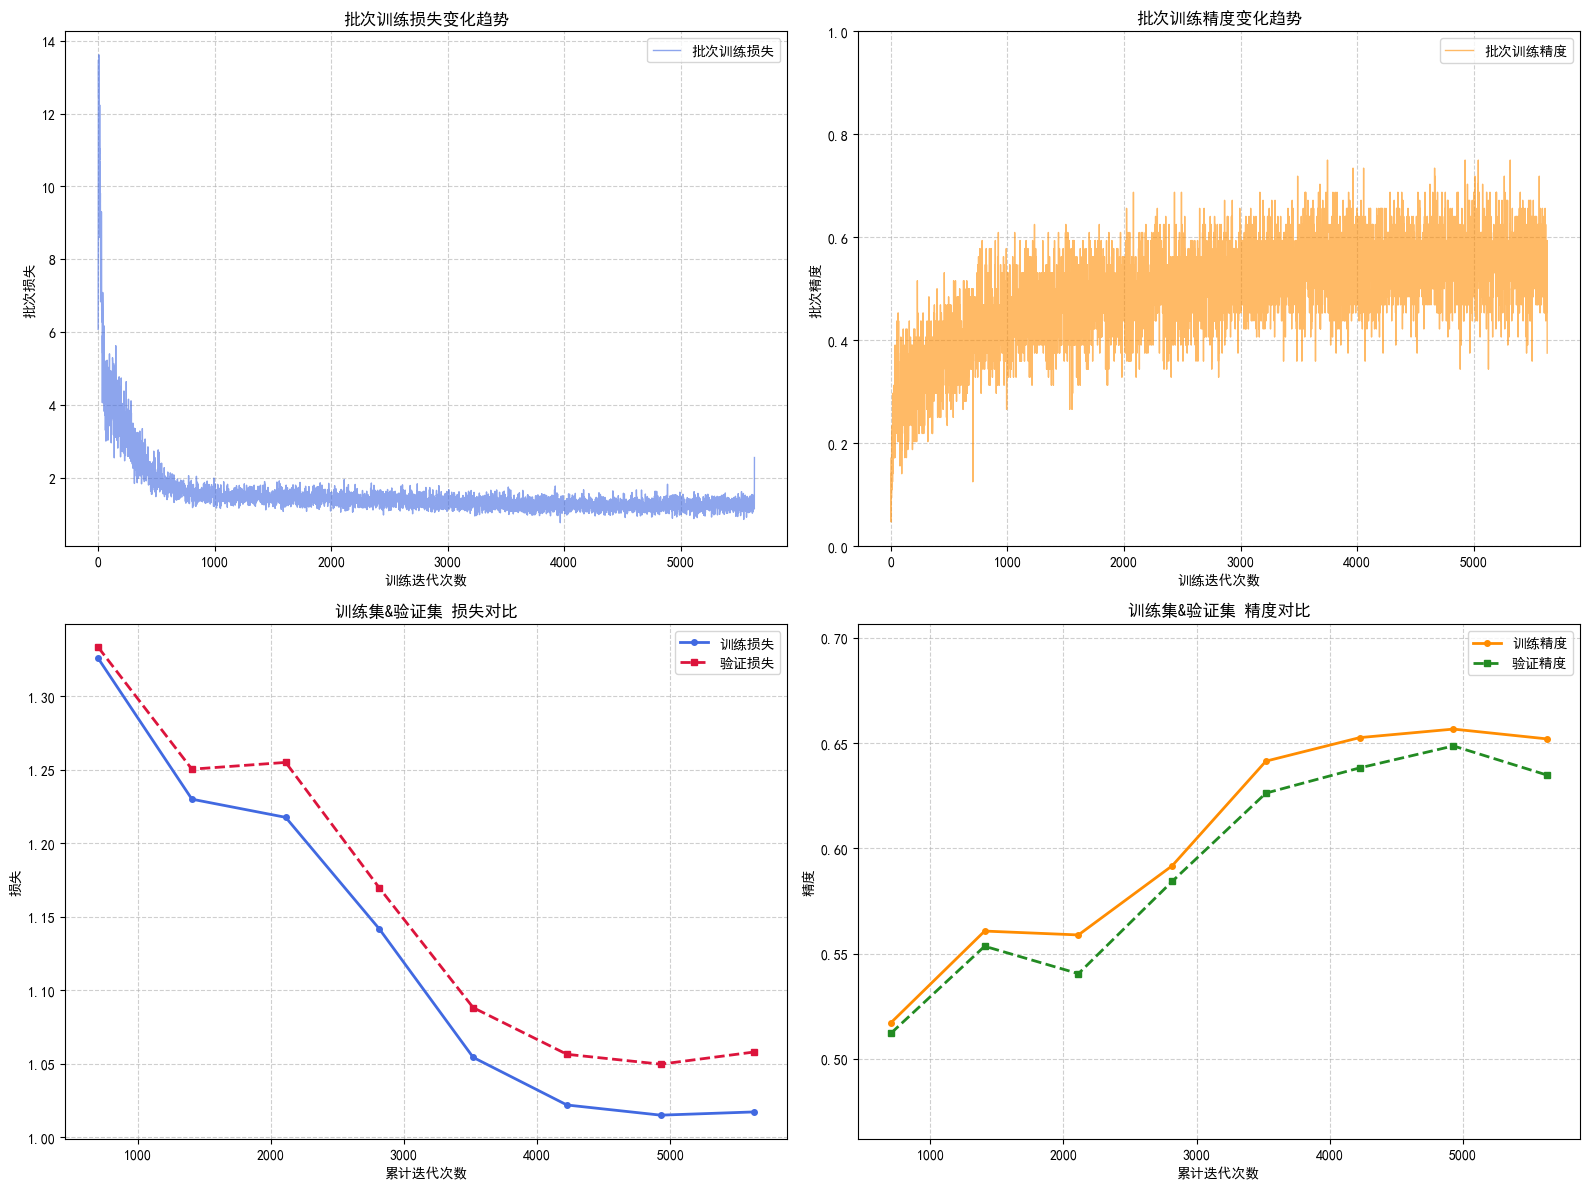

In [11]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=64,
        num_epochs=8,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer2,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        shuffle=True,
        save_dir='best_models'
    )


In [12]:
test_loss, test_acc = runner2.evaluate(test_set, batch_size=64)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 1.06654, Test accuracy: 0.62729


In [14]:
adv_test_images = fgsm_attack(
    model=model2,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn2,
    epsilon=1/255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner2.evaluate(test_set_adv, batch_size=64)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 1.32565, Test accuracy: 0.51075
